In [471]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from heapq import nsmallest
from scipy.signal import butter, lfilter, freqz
from scipy.fftpack import fft, ifft
from scipy import integrate

In [535]:
Atomic_lines = pd.read_csv('atomic_lines.tsv', delimiter = '\t', usecols = ['element', 'wave_A','loggf'], header = 0, low_memory=False, keep_default_na= False)
Atomic_lines

,element,wave_A,loggf
0,Fe 1,3000.003,-4.032
1,C2 1,3000.004,-16.576
2,Fe 1,3000.020,-9.098
3,Fe 1,3000.021,-7.178
4,Mn 2,3000.028,-8.300
...,...,...,...
731372,OH 1,10999.911,-14.634
731373,C2 1,10999.925,-11.319
731374,Y 2,10999.938,-5.557
731375,CO 1,10999.971,-11.809


In [536]:
Fe1 = Atomic_lines[Atomic_lines['element']=='Fe 1']
Fe2 = Atomic_lines[Atomic_lines['element']=='Fe 2']
Ti2 = Atomic_lines[Atomic_lines['element']=='Ti 2']
H1 = Atomic_lines[Atomic_lines['element']=='H 1']
Ca1 = Atomic_lines[Atomic_lines['element']=='Ca 1']
Ca2 = Atomic_lines[Atomic_lines['element']=='Ca 2']

In [550]:
Ca1_new = Ca1[(Ca1['wave_A'] >= 3800) & (Ca1['wave_A'] <= 5750)]
Ca2_new = Ca2[(Ca2['wave_A'] >= 3800) & (Ca2['wave_A'] <= 5750)]
H1_new  =  H1[(H1 ['wave_A'] >= 3800) & (H1 ['wave_A'] <= 5750)]
Fe1_new = Fe1[(Fe1['wave_A'] >= 3870) & (Fe1['wave_A'] <= 3875)]
Fe1_new.index = list(range(len(Fe1_new)))
Fe2_new = Fe2[(Fe2['wave_A'] >= 3800) & (Fe2['wave_A'] <= 5750)]
Ti2_new = Ti2[(Ti2['wave_A'] >= 3800) & (Ti2['wave_A'] <= 5750)]
Ti2_new.index = list(range(len(Ti2_new)))


In [395]:
combine_parcial =  pd.read_csv('zetaAur-eclipse_B_2019_10_25_edit.csv', delimiter = '\t', header = 0)
combine_parcial.columns = ['L','I', 'C']
combine_parcial['L'] = combine_parcial['L']*10
combine_parcial['I'] = (combine_parcial['I']*1.8 + 0.5)

In [396]:
dx = np.diff(combine_parcial['I'])/np.diff(combine_parcial['L'])
dy = dx.tolist()
dy.append(0)

In [398]:
def get_fs(Data):
    difer = 0
    for i in range(1,len(combine_parcial['L'])): 
        difer += combine_parcial['L'][i] - combine_parcial['L'][i-1]
    return difer/(len(combine_parcial['L'])-1)
               
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_lowpass(highcut, fs, order=5):
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = butter(order, high, btype='low')
    return b, a


def butter_lowpass_filter(data, highcut, fs, order=5):
    b, a = butter_lowpass( highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def FFT(Data,fs):
    N = len(Data)
    T = 1/fs
    yf = fft(Data)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    return [xf, yf, N]

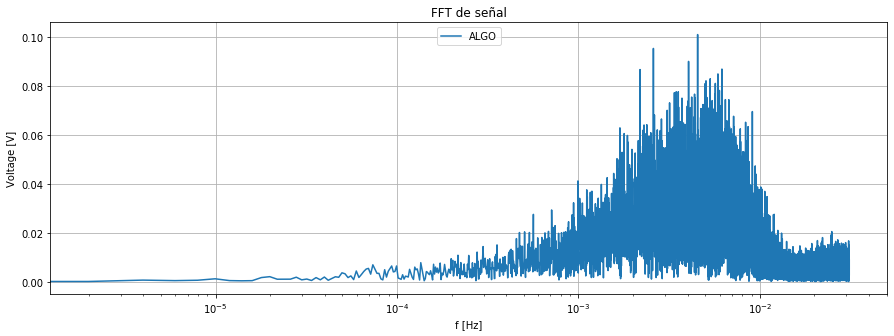

In [399]:
f,_FFT, N = FFT(dy,fs)

#verificar que la frecuencia de corte de todas, están en la misma posición
plt.figure(1, figsize = [15,5])
plt.title("FFT de señal")
plt.ylabel('Voltage [V]')
plt.xlabel('f [Hz]')
plt.plot(f, 2.0/N * np.abs(_FFT[0:N//2]),label='ALGO')
plt.xscale('log')
plt.legend(loc='upper center')
plt.grid()
#plt.show()

In [400]:
fs = get_fs(dy)

In [432]:
newdy = butter_lowpass_filter(dy,0.008,fs,1)
highpass_Inte = butter_bandpass_filter(combine_parcial['I'],0.00008,0.03,fs,2)
newdy

array([ 0.45464657,  1.5267536 ,  1.66465491, ..., -0.50279332,
        0.95663662,  1.09311343])

In [433]:
minpeaks = newdy<-1.5
maxpeaks = newdy>1.5

In [434]:
print(len(combine_parcial['L']))

31323


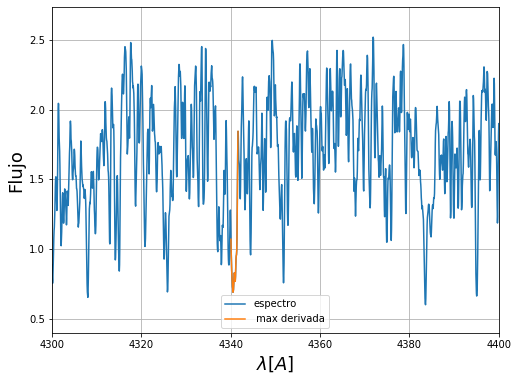

In [525]:
#Graficamos todo el ezspectro en la banda del azul
plt.figure(figsize = [8,6])
#plt.plot(puro['L'],puro['I'],marker='', ls='-', label = 'gigante_puro')
#plt.plot(combine_parcial['L'][1008:1160],newdy[1008:1160],marker='', ls='--', label = ' nueva derivada')
#plt.plot(combine_parcial['L'][1008:1160],minpeaks[1008:1160],marker='', ls='-', label = ' min derivada')
#plt.plot(combine_parcial['L'][1008:1160],maxpeaks[1008:1160],marker='', ls='-', label = ' max derivada')


plt.plot(combine_parcial['L'],combine_parcial['I'],marker='', ls='-', label = 'espectro')
plt.plot(lambdas[191], Intensidades[191],marker='', ls='-', label = ' max derivada')

#plt.plot(combine_parcial['L'],highpass_Inte ,marker='', ls='-', label = 'espectro')
#plt.plot(combine_puro['L'],combine_puro['I']*1.8,marker='', ls='-', label = 'sin_contacto')
plt.xlim(4300,4400)
#plt.ylim(-2.5, 3)
plt.grid()
plt.legend(loc="best")
plt.ylabel("Flujo",fontsize=18)
plt.xlabel("$\lambda [A]$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()

In [496]:
Data_complete = pd.DataFrame(columns = ['L','I', 'dI', 'mins', 'maxs'])
Data_complete['L'] = combine_parcial['L']
Data_complete['I'] = combine_parcial['I']
Data_complete['dI'] = newdy
Data_complete['mins'] = newdy<-1.5
Data_complete['maxs'] = newdy>1.5
Data_complete

,L,I,dI,mins,maxs
0,3799.870770,1.036497,0.454647,False,False
1,3799.922175,1.114556,1.526754,False,True
2,3799.973577,1.267300,1.664655,False,True
3,3800.024975,1.295184,0.992054,False,False
4,3800.076369,1.322956,0.554999,False,False
...,...,...,...,...,...
31318,5748.722852,1.119036,-0.084921,False,False
31319,5748.796492,1.591637,0.667756,False,False
31320,5748.870126,1.291672,-0.502793,False,False
31321,5748.943755,1.402093,0.956637,False,False


In [497]:
mins_ant = False
maxs_ant = False
is_new_window = False 
window = []
for i in Data_complete.index:
    mins_new = Data_complete['mins'][i]
    if mins_new==True and mins_ant== False:
        init_peak = i
        is_new_window = True
    maxs_new = Data_complete['maxs'][i]
    if maxs_new==False and maxs_ant== True and is_new_window == True:
        final_peak = i
        if final_peak > init_peak:
            _window = [init_peak, final_peak]
            window.append(_window)
            is_new_window = False
    mins_ant = mins_new
    maxs_ant = maxs_new

window = pd.DataFrame(window)

In [498]:
indice_pico = []
Intensidades = []
lambdas = []
for i in range(0,len(window)):
    intensidades = Data_complete['I'][window[0][i]:window[1][i]]
    Intensidades.append(intensidades)
    lambdas.append(Data_complete['L'][window[0][i]:window[1][i]])
    minimo = min(intensidades)
    indice_pico.append(intensidades[intensidades == minimo].index.tolist()[0])

In [517]:
EW = []
for i in range(len(Intensidades)):
    length = Intensidades[i].size-1
    vy_prom = max([Intensidades[i].iloc[0], Intensidades[i].iloc[length]])
    Aprom = vy_prom*( lambdas[i].iloc[length] - lambdas[i].iloc[0])
    Abajo_abs = integrate.simps(Intensidades[i], lambdas[i])
    Area = Aprom - Abajo_abs
    EW.append(Area/vy_prom)

In [559]:
Lista4 = pd.DataFrame(columns = ['L', 'I', 'EW'])
Lista4['L'] = [Data_complete["L"][i] for i in indice_pico]
Lista4['I'] = [Data_complete["I"][i] for i in indice_pico]
Lista4['EW'] = EW
Lista4

,L,I,EW
0,3808.200037,1.833573,0.188333
1,3811.898208,1.995339,0.027959
2,3813.059327,1.162616,0.135490
3,3813.462742,1.169456,0.115484
4,3814.671587,0.856314,0.237604
...,...,...,...
955,5727.591876,1.404026,0.080231
956,5731.193814,1.171427,0.098759
957,5735.678745,1.372049,0.058444
958,5737.094928,1.216182,0.080230


In [538]:
Ti2_new

,element,wave_A,loggf
119838,Ti 2,3801.824,-4.409
120307,Ti 2,3804.999,-2.995
120451,Ti 2,3805.985,-3.657
120692,Ti 2,3807.486,-6.667
121598,Ti 2,3813.388,-1.890
...,...,...,...
402468,Ti 2,5723.781,-4.794
403428,Ti 2,5734.852,-8.514
403429,Ti 2,5734.853,-6.719
403501,Ti 2,5735.702,-5.182


In [549]:
key = lambda x: abs(x-Ti2_new['wave_A'][0])
Data_complete['L']
Ti2_new['wave_A']

119838    3801.824
120307    3804.999
120451    3805.985
120692    3807.486
121598    3813.388
            ...   
402468    5723.781
403428    5734.852
403429    5734.853
403501    5735.702
403758    5738.962
Name: wave_A, Length: 1144, dtype: float64

In [612]:
new_list = []
gf = []
for i in range(len(Ti2_new['wave_A'])):
    y = abs(nsmallest(1,Lista4['L'], key = lambda x: abs(x-Ti2_new['wave_A'][i]))[0] - Ti2_new['wave_A'][i])
    if y < 0.01:
        new_list.append(nsmallest(1,Lista4['L'], key = lambda x: abs(x-Ti2_new['wave_A'][i]))[0])
        gf.append(Ti2_new['loggf'][i])

In [613]:
Lista5 = pd.DataFrame(columns = ['L', 'I', 'EW','loggf'])
L = []
I = []
EW = []
loggf = []
logEWl = []
for i in range(len(new_list)-1):
    L.append(Lista4[Lista4["L"] == new_list[i]]['L'].tolist()[0])
    I.append(Lista4[Lista4["L"] == new_list[i]]['I'].tolist()[0])
    EW.append(Lista4[Lista4["L"] == new_list[i]]['EW'].tolist()[0])
    loggf.append(gf[i])
    logEWl.append(np.log(EW[i]))
Lista5['L'] = L
Lista5['I'] = I
Lista5['EW'] = EW
Lista5['loggf'] = loggf
Lista5['logEW'] = logEWl
Lista5

,L,I,EW,loggf,logEW
0,4005.311606,1.083899,0.069488,-2.520,-2.666597
1,4077.807057,0.546938,0.400613,-2.970,-0.914759
2,4114.486529,1.604024,0.027999,-4.199,-3.575578
3,4432.089944,1.540070,0.042240,-3.080,-3.164386
4,4458.167637,1.388344,0.128468,-12.248,-2.052073
5,4458.167637,1.388344,0.128468,-8.801,-2.052073
6,4489.052635,1.239453,0.165979,-2.536,-1.795892
7,4512.758083,1.332606,0.111345,-6.697,-2.195124
8,4513.638266,1.681181,0.097075,-2.640,-2.332267
9,4589.966041,1.453175,0.105867,-1.620,-2.245569


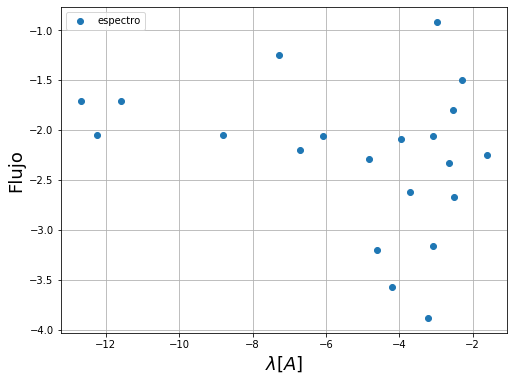

In [614]:
#Graficamos todo el ezspectro en la banda del azul
plt.figure(figsize = [8,6])
plt.plot(Lista5['loggf'],Lista5['logEW'],marker='o', ls='', label = 'espectro')

#plt.xlim(4300,4400)
#plt.ylim(-2.5, 3)
plt.grid()
plt.legend(loc="best")
plt.ylabel("Flujo",fontsize=18)
plt.xlabel("$\lambda [A]$",fontsize=18)
#plt.xscale('log')
#plt.yscale('log')
#plt.legend(fontsize = 14)
plt.show()

In [615]:
len(new_list)

22

In [563]:
new_list[0]

3801.8215124993694

In [ ]:
media = []
for i in range(100,len(combine_parcial['I'])):
    suma = 0
    for j in range(i-100, i):
        suma += combine_parcial['I'][j]
    media.append(suma/100)

In [ ]:
plt.figure(figsize = [8,6])
plt.plot(combine_parcial['L'],combine_parcial['I'] ,marker='', ls='-', label = 'espectro')
plt.plot(combine_parcial['L'][100:],media,marker='', ls='-', label = 'media movil')

#plt.xlim(3800,4200)
#plt.ylim(-2.5, 3)
plt.grid()
plt.legend(loc="best")
plt.ylabel("Flujo",fontsize=18)
plt.xlabel("$\lambda [A]$",fontsize=18)
#plt.legend(fontsize = 14)
plt.show()